- Distance hist 500 [clelia not sure if smart idea, so do this to test the idea]
    - [ ] 10 runs MCM 0 for 500 samples, overlap co- ocurrence matrices, calculate expected number icc and cluster to this amount
    - [ ] Then use new-found “average mcm”.
    - [ ] From all samples used, take union of unique elements (so exclude the ones we did not see and remove duplicates) and recalculate counts and Len data
    - [ ] Now compare the distance hist we get for 500 with the one from a single run 5k -> compare against all digits and single some out like last time
    - [ ] Goal: want to know if this average mcm is really needed instead of just using a single run one

In [108]:
import numpy as np
import os
import json
import sys
import matplotlib.pyplot as plt
import skimage

sys.path.append("../")
import src.plot as myplot
import seaborn as sns

import sklearn

In [109]:
import importlib
import src.plot as myplot
importlib.reload(myplot)

<module 'src.plot' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/0_classifier/paper_plots/../src/plot.py'>

In [110]:

import importlib
import src.paper_utils as utils
importlib.reload(utils)

<module 'src.paper_utils' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/0_classifier/paper_plots/../src/paper_utils.py'>

In [111]:
sample_sizes = [500, 5000]
counts_samplesizes, mcms_samplesizes = utils.load_counts_mcm(sample_sizes, letter="", path_format="../Output/sample_sizes")


In [112]:
mcm_digit = 0
mcms_500 = mcms_samplesizes[sample_sizes.index(500)]
nr_runs = len(mcms_500)

coo_500 = np.array([myplot.create_cooccurance_matrix(mcms_500[i][mcm_digit]) for i in range(nr_runs)],dtype=int)



In [113]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
import numpy as np

mean_nr_icc = np.mean([len(mcm[mcm_digit]) for mcm in mcms_500])

m = coo_500.sum(axis=0)
linkage = sch.linkage(m, method="ward")
labels = sch.fcluster(linkage, t=mean_nr_icc, criterion="maxclust")
sorted_indices = np.argsort(labels)
sorted_m = m[sorted_indices[:,None],sorted_indices]


In [114]:
avg_mcm = labels.reshape((11,11))

In [115]:
avg_mcm.max()

31

In [116]:
# show training set and construct counts
# get training set for each 500 using the seed, get the union without duplicates
# construct counts

# utils.recreate_dataset("",0,500,seed=s, fname_format = "train-images-unlabled-{}.dat",fname_start="train-")
# utils.subsample_data(500, all_data_path="../INPUT_all/data", input_data_path="../INPUT/data", seed=42,fname_start = "train-")
samp = np.array([utils.recreate_dataset("",mcm_digit, 500, seed = s+1,fname_format= "train-images-unlabeled-{}.dat", fname_start="train-", all_data_path="../INPUT_all/data/", input_data_path = "../INPUT/data/") for s in range(10)])
samp = np.unique(samp)

In [117]:


def partition_to_str(mcm):
    """Take a partition map labeling 11x11 array and return the original string representation"""
    nr_icc = mcm.max()
    out = []

    for icc in range(1, nr_icc+1):
        idx = np.argwhere(mcm.flatten()==icc).flatten()
        x = np.zeros(121,dtype=int)
        x[idx] = 1
        out.append("".join(map(str, x)))
    return np.array(out, dtype=str)


In [118]:
icc = 1
samp_gen = np.genfromtxt(samp, delimiter=1, dtype=int)
n_variables = avg_mcm.max()
Counts = []
for icc in range(1, n_variables+1):
    idc = np.argwhere(avg_mcm.flatten()==icc).flatten()
    p_count = np.zeros(2**len(idc))
    icc_strings = [int("".join([str(s) for s in state]), 2) for state in samp_gen[:,idc]]

    u,c = np.unique(icc_strings, return_counts=True)

    p_count[u] = c  
    Counts.append(list(p_count))


Compute distance hist

In [119]:



n_runs = 10
mcm_digit = 0

nr_digits = 10
sample_sizes = [500,5000]

test_probs = np.zeros((len(sample_sizes), n_runs,nr_digits, len(utils.load_test_data(digit=0))))

for test_digit in range(nr_digits):
    test_data = utils.load_test_data(digit=test_digit)

    for sample_size_idx, sample_size in enumerate(sample_sizes):

        mcms = mcms_samplesizes[sample_size_idx][:n_runs]
        counts_gstar = counts_samplesizes[sample_size_idx][:n_runs]
            
        for run_idx, mcm in enumerate(mcms):
            test_probs[sample_size_idx][run_idx][test_digit] = utils.probabilities_gstar(mcm[mcm_digit], counts_gstar[run_idx][mcm_digit], test_data, sample_size,smooth=True)


In [128]:
len(samp), sum(Counts[0])

(3397, 3397.0)

In [120]:
test_probs_avg500 = np.zeros((len(utils.load_test_data(digit=0)),10))
for test_digit in range(nr_digits):
    test_data = utils.load_test_data(digit=test_digit)

    test_probs_avg500[:,test_digit] = utils.probabilities_gstar(list(partition_to_str(avg_mcm)), Counts, test_data, len(samp),smooth=True)


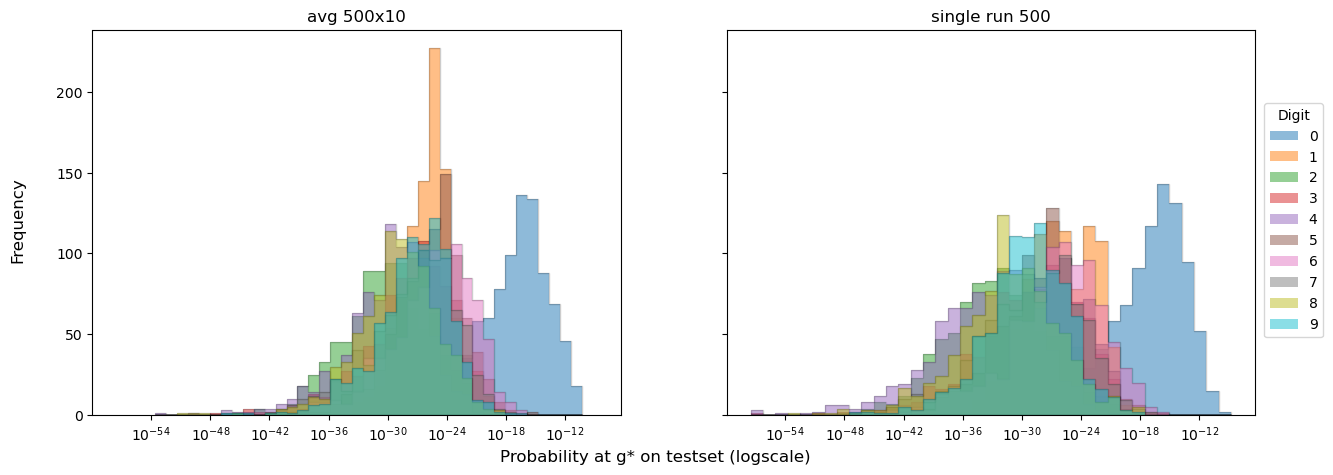

In [131]:
colors = myplot.get_list_fromcmap("tab10", N=10)
fig, axs = plt.subplots(1,2, figsize=(15,5),sharex=True, sharey=True)
axs = np.ravel(axs)
for idx, data in enumerate([test_probs_avg500,test_probs[sample_sizes.index(500),2].T]):

    ax = axs[idx]

    logbins = np.geomspace(data.min(),data.max(), 40)

    for i in range(10):
        ax.hist(data[:, i],bins=logbins, label=f'{i}',alpha=.5,histtype= "stepfilled",facecolor=colors[i])
        ax.hist(data[:, i],bins=logbins, facecolor="None",alpha=.2,edgecolor="black",histtype= "stepfilled")


    ax.set_title(["avg 500x10","single run 500"][idx])
    ax.set_xscale("log")

handles, labels = ax.get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='center right', ncol=1,bbox_to_anchor=(.95,0.5),title="Digit")


fig.supxlabel("Probability at g* on testset (logscale)")

supylabel = fig.supylabel('Frequency')
supylabel.set_x(supylabel.get_position()[0] + 0.05)



plt.show()




In [122]:
data = test_probs[ss_idx,0].T
data.shape

(892, 10)

IndexError: index 1 is out of bounds for axis 0 with size 1

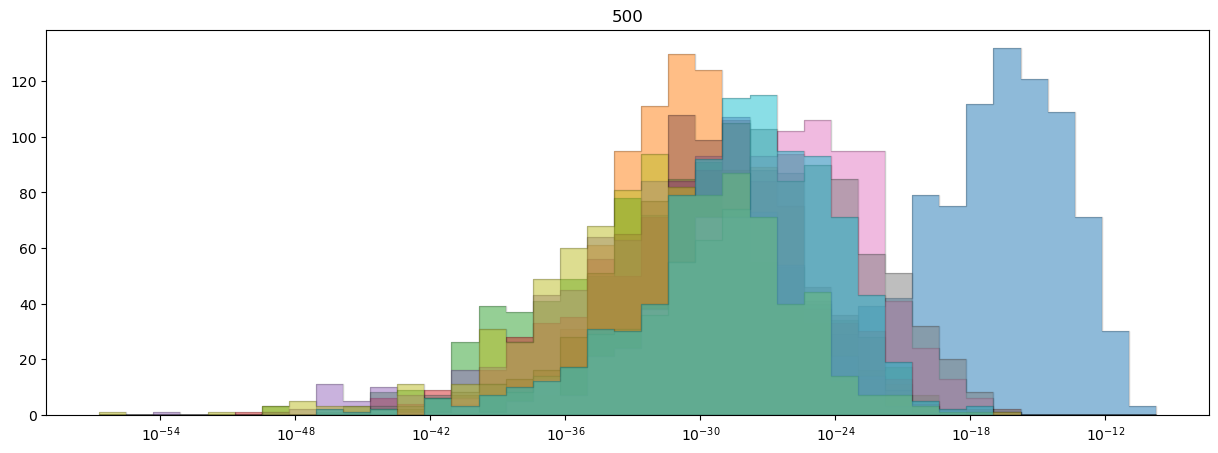

In [123]:
colors = myplot.get_list_fromcmap("tab10", N=10)
fig, axs = plt.subplots(1,1, figsize=(15,5),sharex=True, sharey=True)
axs = np.ravel(axs)
for ss_idx, sample_size in enumerate(sample_sizes):
    data = test_probs[ss_idx,0].T
    ax = axs[ss_idx]

    logbins = np.geomspace(data.min(),data.max(), 40)

    for i in range(10):
        ax.hist(data[:, i],bins=logbins, label=f'{i}',alpha=.5,histtype= "stepfilled",facecolor=colors[i])
        ax.hist(data[:, i],bins=logbins, facecolor="None",alpha=.2,edgecolor="black",histtype= "stepfilled")



    # if ss_idx == len(sample_sizes)-3:
    #     handles, labels = ax.get_legend_handles_labels()
    #     ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)

    ax.set_title(sample_size)
    ax.set_xscale("log")

handles, labels = ax.get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='center right', ncol=1,bbox_to_anchor=(.95,0.5))


fig.supxlabel("Probability at g* on testset (logscale)")

supylabel = fig.supylabel('Frequency')
supylabel.set_x(supylabel.get_position()[0] + 0.05)



plt.show()


